In [26]:
import pandas as pd
import torch
from transformers import AutoModelForMaskedLM
from src import perplexity, get_model, get_dataloaders
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Statistics

Best model: `(('0.001', '256', '0.05'), tensor(1.7515))`

In [19]:
best_model_args = {
    "from_model": "Rostlab/prot_bert_bfd",
    "from_adapters": "./models/hps/LR0.001_BS256_P0.05/best/",
}

best_model = get_model(best_model_args)
best_model.to(device).to(torch.bfloat16)

base_model = AutoModelForMaskedLM.from_pretrained("Rostlab/prot_bert_bfd")
base_model.to(device).to(torch.bfloat16)

thermo_args = {
    "from_tokenizer": "Rostlab/prot_bert_bfd",
    "training_set": "./data/_test.csv",
    "min_length": None,
    "max_length": None,
    "mask": False,
    "p": 0,
    "local_batch_size": 8,
    "num_workers": 8,
}

non_thermo_args = {
    "from_tokenizer": "Rostlab/prot_bert_bfd",
    "training_set": "./data/non_thermo.csv",
    "min_length": None,
    "max_length": None,
    "mask": False,
    "p": 0,
    "local_batch_size": 8,
    "num_workers": 8,
}

thermo_dataloader = get_dataloaders(thermo_args, shuffle=False, return_validation=False)
non_thermo_dataloader = get_dataloaders(non_thermo_args, shuffle=False, return_validation=False)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificati

In [42]:
hue = ["thermo"]*len(thermo_dataloader.dataset) + ["non thermo"]*len(non_thermo_dataloader.dataset)
hue = pd.Series(hue)

In [22]:
best_model_perplexity = torch.empty(0)
for batch in thermo_dataloader:
    input_ids = batch.input_ids
    attention_mask = batch.attention_mask
    perp = perplexity(model=best_model, input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
    best_model_perplexity = torch.concat([best_model_perplexity, perp.cpu()])
for batch in non_thermo_dataloader:
    input_ids = batch.input_ids
    attention_mask = batch.attention_mask
    perp = perplexity(model=best_model, input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
    best_model_perplexity = torch.concat([best_model_perplexity, perp.cpu()])
best_model_perplexity = pd.Series(best_model_perplexity)

In [23]:
base_model_perplexity = torch.empty(0)
for batch in thermo_dataloader:
    input_ids = batch.input_ids
    attention_mask = batch.attention_mask
    perp = perplexity(model=base_model, input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
    base_model_perplexity = torch.concat([base_model_perplexity, perp.cpu()])
for batch in non_thermo_dataloader:
    input_ids = batch.input_ids
    attention_mask = batch.attention_mask
    perp = perplexity(model=base_model, input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
    base_model_perplexity = torch.concat([base_model_perplexity, perp.cpu()])
base_model_perplexity = pd.Series(base_model_perplexity)

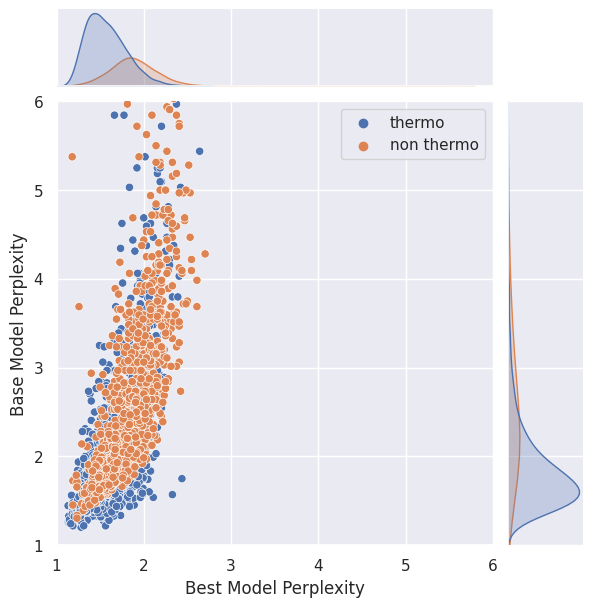

In [43]:
sns.jointplot(x=best_model_perplexity, y=base_model_perplexity, hue=hue)
plt.xlim(1, 6)
plt.ylim(1, 6)
plt.xlabel("Best Model Perplexity")
plt.ylabel("Base Model Perplexity")
plt.show()